In [21]:
import os, sys, importlib
sys.path.append('../')

import common_utils
from common_utils import plotting, training
import glob
import numpy as np

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
hep.style.use(hep.style.ATLAS)


In [22]:
saved_data = './cached_data/'

dataset = pd.read_hdf(f"{saved_data}dataset_preselected_ttbar.h5", key="dataset", mode='r')

mask_ttbar = dataset.type=='ttbar'
mask_singletop = dataset.type=='single_top_t_chan'
mask_wjets = dataset.type=='wjets'

# mask that extracts the expected Asimov dataset - 
# trivially the full dataset for the ttbar dataset used here, 
# but not generally true
mask_Asimov = (dataset.type=='ttbar') | (dataset.type=='single_top_t_chan') | (dataset.type=='wjets')
weights_Asimov = jnp.array(dataset[mask_Asimov].weights.ravel())

dataset_ttbar = dataset[mask_ttbar].copy()
dataset_single_top = dataset[mask_singletop].copy()
dataset_wjets = dataset[mask_wjets].copy()

nu_ttbar = dataset_ttbar.weights.sum()
print(f"expected ttbar yield = {nu_ttbar} events")

nu_singletop = dataset_single_top.weights.sum()
print(f"expected single top yield = {nu_singletop}")

nu_wjets = dataset_wjets.weights.sum()
print(f"expected wjets yield = {nu_wjets}")

expected ttbar yield = 4800509.33982328 events
expected single top yield = 281062.7552821169
expected wjets yield = 9155266.317030579


In [24]:
path_to_ratios_wjets = './output_ratios_wjets/'
path_to_ratios_singletop = './output_ratios_singletop/'

files_wjets = glob.glob(f"{path_to_ratios_wjets}ratio_*bs512*42.npy")
files_singletop = glob.glob(f"{path_to_ratios_singletop}ratio_*bs512*.npy")

ratios = {}
ratios['wjets'] = jnp.array(np.load(files_wjets[0])[mask_Asimov])
ratios['singletop'] = jnp.array(np.load(files_singletop[0])[mask_Asimov])
ratios['ttbar'] = jnp.array(np.ones_like(ratios['wjets'])[mask_Asimov])


In [25]:
# Build the model

# rate term
@jax.jit
def nu(mu):

    nu = mu * nu_ttbar + nu_singletop + nu_wjets

    return nu


# per event term
@jax.jit
def log_ratio_mu(mu):

    dnu_mu = mu * nu_ttbar * ratios['ttbar']\
                + nu_singletop * ratios['singletop']\
                + nu_wjets * ratios['wjets']

    return jnp.log( dnu_mu / nu(mu) ) 


# The full NLL function
@jax.jit
def full_nll_function(mu, mu_Asimov=1.0):

    pois_llr = -2 * nu(mu_Asimov) * jnp.log(nu(mu)) + 2 * nu(mu)
    nsbi_llr = -2 * jnp.sum(jnp.multiply(weights_Asimov, log_ratio_mu(mu)))

    return pois_llr + nsbi_llr

In [26]:
from iminuit import Minuit

param_vec = ['mu']
param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(full_nll_function, param_tuple, grad=None, name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES
strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.511e+08                 │              Nfcn = 23               │
│ EDM = 0.00013 (Goal: 0.0002)     │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │  1.7831   │  0.0007   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────┐
│    │       mu │
├────┼──────────┤
│ mu │ 4.23e-07 │
└────┴──────────┘

Text(1, 0, '$\\mu_{t\\bar{t}}$')

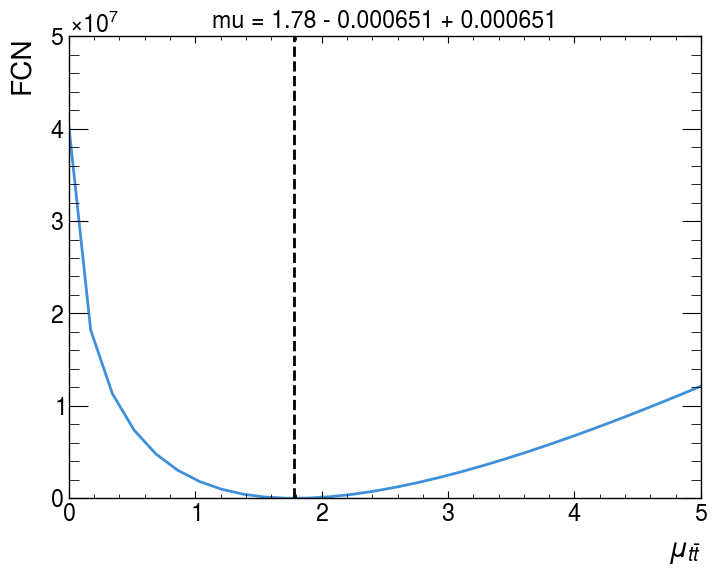

In [29]:
m1.draw_mnprofile('mu', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t\bar{t}}$')

So the best-fit value from the toy analysis with Asimov dataset does not converge to the truth value - $\widehat{\mu}_{t\bar{t}} \neq \mu^\text{truth}_{t\bar{t}} = 1.0$.

Unlike a binned Poisson likelihood fit, which by definition converges to the truth value for Asimov and has well-defined asymptotic statistical properties - this is not guaranteed in an NSBI analysis.

In [30]:
# rate term
def nu(mu_vec):
    
    mu, mu_singletop, mu_wjets = mu_vec
    nu = mu * nu_ttbar \
        + mu_singletop * nu_singletop \
        + mu_wjets * nu_wjets

    return nu
    
# per event term
def log_ratio_mu(mu_vec):

    mu, mu_singletop, mu_wjets = mu_vec
    dnu_mu = mu * nu_ttbar * ratios['ttbar']\
            + mu_singletop * nu_singletop * ratios['singletop']\
            + mu_wjets * nu_wjets * ratios['wjets']

    return jnp.log( dnu_mu / nu(mu_vec) ) 

# The full NLL function
def full_nll_function(mu):

    mu_Asimov=[1.0, 1.0, 1.0]
    
    pois_llr = -2 * nu(mu_Asimov) * jnp.log(nu(mu)) + 2 * nu(mu)
    nsbi_llr = -2 * jnp.sum(jnp.multiply(weights_Asimov, log_ratio_mu(mu)))

    return pois_llr + nsbi_llr

In [31]:
from iminuit import Minuit

param_vec = ['mu', 'mu_singletop', 'mu_wjets']
param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(full_nll_function, param_tuple, grad=None, name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES

limits = []
for param_ in enumerate(param_vec):
    
    limits.append([1e-10,None])
        
limits = tuple(limits)
m1.limits = limits

strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.534e+08                 │              Nfcn = 70               │
│ EDM = 2.16e-05 (Goal: 0.0002)    │            time = 3.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu           │  1.9385   │  0.0007   │            │            │  1e-10  │         │       │
│ 1 │ mu_singletop │     0     │  2.5e-6   │            │            │  1e-10  │         │       │
│ 2 │ mu_wjets     │ 538.63e-3 │  0.28e-3  │            │            │  1e-10  │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬────────────────────────────────────────┐
│              │           mu mu_singletop     mu_wjets │
├──────────────┼────────────────────────────────────────┤
│           mu │     4.64e-07    19.62e-15     -0.03e-6 │
│ mu_singletop │    19.62e-15     1.92e-16    -7.51e-15 │
│     mu_wjets │     -0.03e-6    -7.51e-15      7.6e-08 │
└──────────────┴────────────────────────────────────────┘

In [32]:
from iminuit import Minuit

# param_vec = ['mu', 'mu_singletop']
param_vec = ['mu', 'mu_singletop', 'mu_wjets']

param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(jax.jit(full_nll_function), param_tuple, grad=None, name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES

limits = []
for param_ in enumerate(param_vec):
    
    limits.append([1e-10,None])
        
limits = tuple(limits)
m1.limits = limits

strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.534e+08                 │              Nfcn = 70               │
│ EDM = 2.16e-05 (Goal: 0.0002)    │            time = 0.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu           │  1.9385   │  0.0007   │            │            │  1e-10  │         │       │
│ 1 │ mu_singletop │     0     │  2.5e-6   │            │            │  1e-10  │         │       │
│ 2 │ mu_wjets     │ 538.63e-3 │  0.28e-3  │            │            │  1e-10  │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬────────────────────────────────────────┐
│              │           mu mu_singletop     mu_wjets │
├──────────────┼────────────────────────────────────────┤
│           mu │     4.64e-07    19.62e-15     -0.03e-6 │
│ mu_singletop │    19.62e-15     1.92e-16    -7.51e-15 │
│     mu_wjets │     -0.03e-6    -7.51e-15      7.6e-08 │
└──────────────┴────────────────────────────────────────┘

In [33]:
from iminuit import Minuit

param_vec = ['mu', 'mu_singletop']
param_vec = ['mu', 'mu_singletop', 'mu_wjets']

param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(jax.jit(full_nll_function), param_tuple, grad=jax.jit(jax.grad(full_nll_function)), name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES

limits = []
for param_ in enumerate(param_vec):
    
    limits.append([1e-10,None])
        
limits = tuple(limits)
m1.limits = limits

strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.534e+08                 │         Nfcn = 26, Ngrad = 7         │
│ EDM = 2.17e-05 (Goal: 0.0002)    │            time = 0.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu           │  1.9385   │  0.0007   │            │            │  1e-10  │         │       │
│ 1 │ mu_singletop │     0     │  2.5e-6   │            │            │  1e-10  │         │       │
│ 2 │ mu_wjets     │ 538.62e-3 │  0.28e-3  │            │            │  1e-10  │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬────────────────────────────────────────┐
│              │           mu mu_singletop     mu_wjets │
├──────────────┼────────────────────────────────────────┤
│           mu │     4.65e-07    22.48e-15     -0.03e-6 │
│ mu_singletop │    22.48e-15     1.97e-16    -9.42e-15 │
│     mu_wjets │     -0.03e-6    -9.42e-15     7.59e-08 │
└──────────────┴────────────────────────────────────────┘

Text(1, 0, '$\\mu_{t\\bar{t}}$')

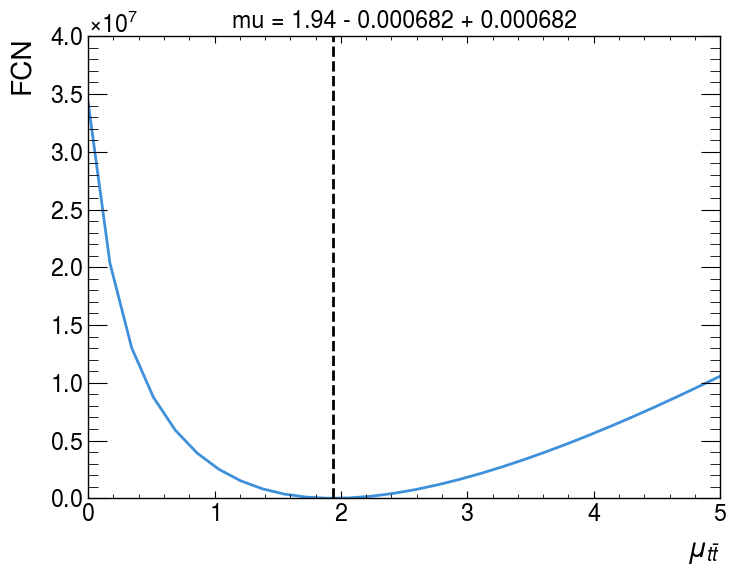

In [37]:
m1.draw_mnprofile('mu', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t\bar{t}}$')

Text(1, 0, '$\\mu_{t}$')

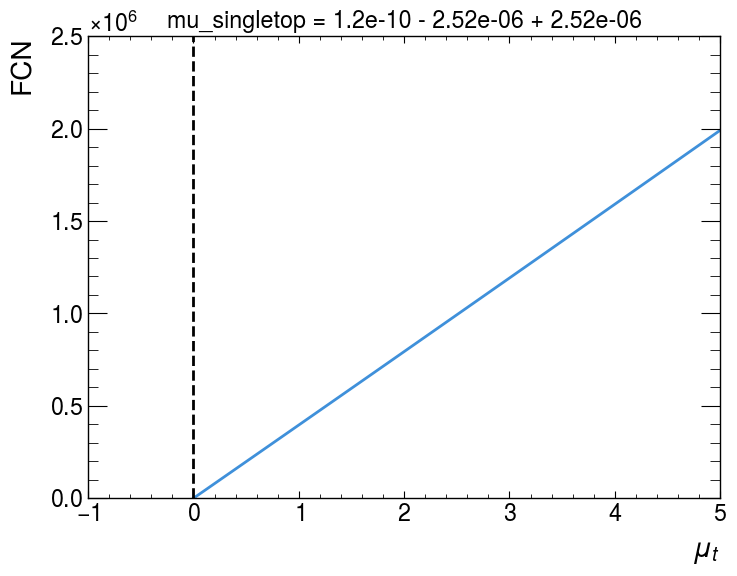

In [38]:
m1.draw_mnprofile('mu_singletop', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t}$')

Text(1, 0, '$\\mu_{t}$')

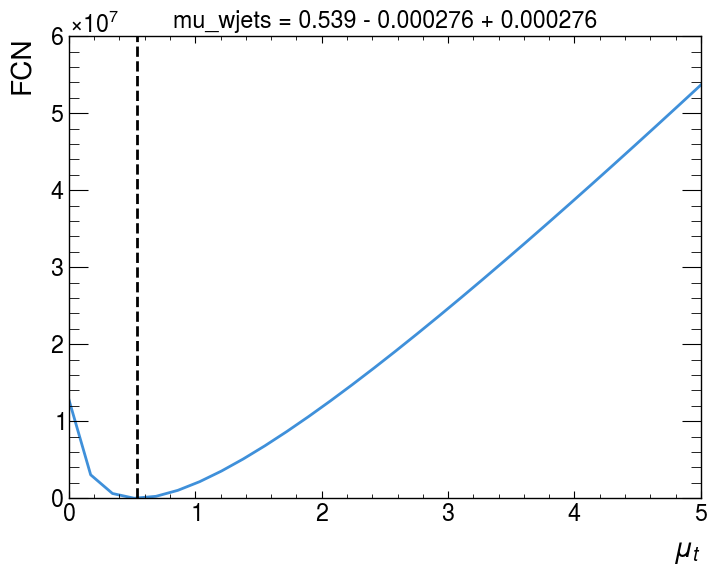

In [39]:
m1.draw_mnprofile('mu_wjets', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t}$')

Optimizing the analysis
===

**As we increase the number of parameters, the robustness of the density ratio modelling becomes more important. Building ensembles and optimizing preselections are important. Each of the $O(100)$ nuisance paramters typical in an LHC analysis needs to be checked for bias.**

Things that can be optimized for better convergence:

- Tighter preselections - removing more of the background-rich phase space $p_{ref}\sim 0$ that can cause numerical instabilites, removing phase space regions with low Monte Carlo statistics or that are difficult to model, etc.
- Changing the hyperparameters of the various NNs used in the modelling.
- Training larger ensembles

The workflow necessarily has to be repeated multiple times until unbiased estimators with robust statistical properties are achieved. Following is the kind of workflow built for the ATLAS analysis:

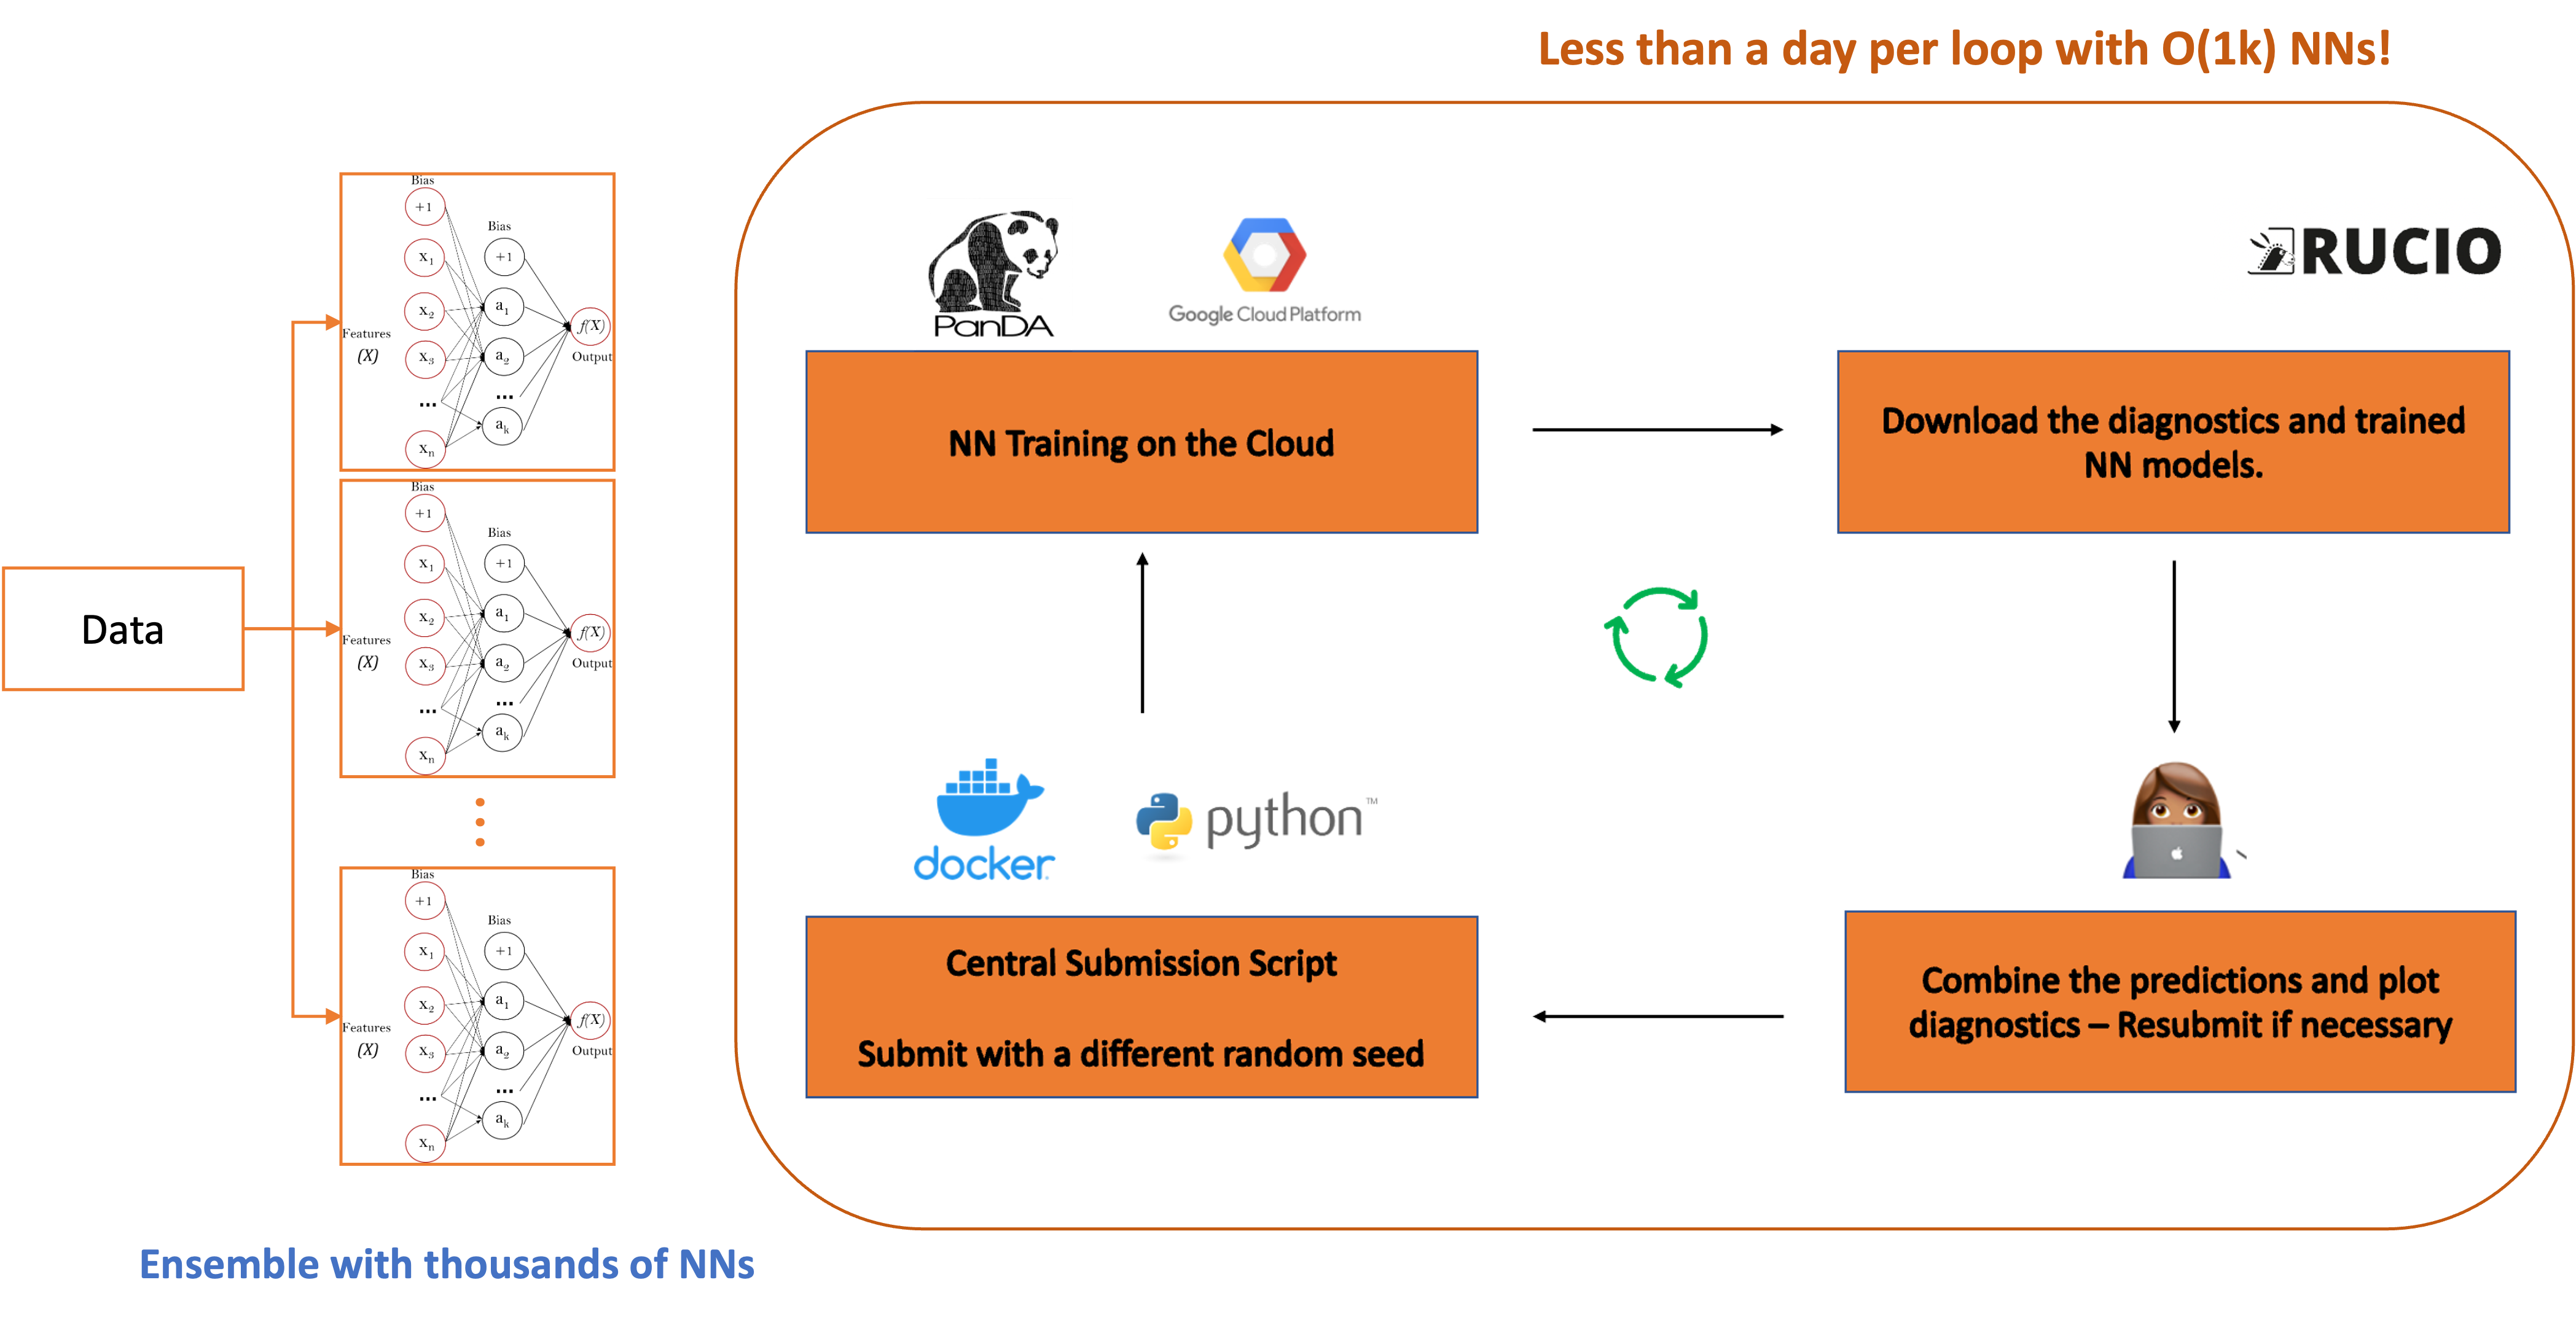




More Diagnostics
===

- **Signal injection tests**
  
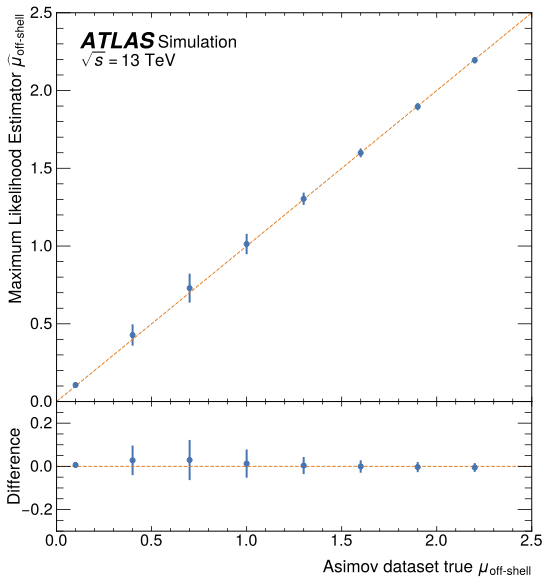

- **Signal injection tests**
  


Things remaining to add to this simplified workflow:

- Constrained nuisance parameters describing systematic uncertainties.
  
- Neyman Construction in an unbinned NSBI framework

  